# Traffic Flow Analysis with Spark: End of Queue Detection

**Contact:** Ahmad Al-Shishtawy ([email](mailto:ahmad.al-shishtawy@ri.se))

### Contents:
- Introduction
- Traffic Flow Data
- Data Exploration
- Fundamental Diagrams of Traffic Flow
- End of Queue Detection
- Visualization
- Next Steps

# Introduction

## SICS ICE Datacenter in Luleå

<img src="img/data_center.jpg" alt="SICS ICE Datacenter" style="width: 320px;"/>

## Hadoop Ecosystem

An ecosystem for **storing** and **processing** large amounts of data.

Basic components:
- Distributed storage
- Computation engine (MapReduce)
- Libraries
- Applications

Designed to run **reliably** on **comodity** servers

<img src="img/Hadoop.png" alt="Hadoop Ecosystem" style="width: 600px;"/>

## Apache Spark

- General purpose in-memory Data Processing engine
- Integrates very well with the Hadoop Ecosystem (and much more)
- Unified engine supporting SQL queries, streaming data, machine learning, and graph processing
- Open source Apache project

<img src="img/Spark.png" alt="Spark" style="width: 700px;"/>

### Credits
The Hadoop and Spark diagrams above are from the [Spark for Dummies **Free** Book](https://www-01.ibm.com/common/ssi/cgi-bin/ssialias?htmlfid=DCM03021USEN)

## Jupyter Notebook

Well, this is a Jupyter notebook :)

It is an interactive document that contain **live code**, **equations**, **visualizations** and explanatory **text**.

Just like this example below. Try changing the code and then execute the cell by pressing (Shift+Enter).

In [1]:
print('Hello World!!')

x = 2
y = 100

print('{} + {} = {}'.format(x, y, x+y))

print('{}^{} = {}'.format(x, y, x**y))

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
1451,application_1511276242554_0869,pyspark,idle,Link,Link,✔


SparkSession available as 'spark'.
Hello World!!
2 + 100 = 102
2^100 = 1267650600228229401496703205376

Jupyter has become the de facto standard used by many data scientist to interactivly analyze data.

<img src="img/Jupyter.png" alt="Jupyter" style="width: 600px;"/>


# Traffic Flow Data

In this demo we will be using traffic flow data generated from radar detectors (sensors) that are part of the Motorway Control System (MCS) distributed along the highways in Stockholm (see the picture below for an example).

The detectors generate data **every minute**. The data contains the **average speed** and the **number of cars** that passed in that minute.

The sensors are identified by two fields:
- Ds_Reference: such as "E4S 61,036", which is composed of the road name "E4" and the direction "S" for south, and the kilometer reference.
- Detector_Number: Detectors are numbered from right to left starting from 1 for the first detector in the rightmost lane.

![Flow Sensors](img/FlowSensors.png)

# Data Exploration

We will use **Spark** to explore and analyze the traffic flow data. But first we need to load the data and do some cleanup.

## Starting Spark

We import some libraries that we will be using then initialize spark

In [2]:
### Uncomment to install missing packages as needed (you may need to restart the kernel)

### 1 - ipyleaflet
### Conda package is old (ver 0.3) so using pip instead (ver 0.4)
# !pip install -U ipyleaflet 
### or
# !conda install -y -c conda-forge ipyleaflet

### 2 - geojson
# !conda install -y geojson

In [3]:
#from ipyleaflet import Map, GeoJSON, TileLayer
#from geojson import FeatureCollection, Feature, MultiPolygon
#import json
#import ipywidgets as widgets
#from  datetime import timedelta, datetime
#import time

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
#%matplotlib inline 

In [4]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import udf, col, lag, datediff, unix_timestamp
from pyspark.sql.window import Window

In [5]:
#spark = SparkSession.builder \
#    .master('local[*]') \
#    .appName('Demo4') \
#    .config('spark.executor.memory', '5g') \
#    .config('spark.driver.memory', '5g') \
#    .getOrCreate()

In [6]:
spark.version

u'2.2.0'

In [7]:
%%local
%matplotlib inline 

## Loading The Data

The data is stored in a csv file (comma seperated values). Spark can parse csv files and can infer the schema but it is better to define the schema specially when dealing with very large datasets.

### Define the schema of the csv file

In [8]:
schema_flow = StructType().add('Timestamp', TimestampType(), False) \
        .add('Ds_Reference', StringType(), False) \
        .add('Detector_Number', ShortType(), False) \
        .add('Traffic_Direction', ShortType(), False) \
        .add('Flow_In', ShortType(), False) \
        .add('Average_Speed', ShortType(), False) \
        .add('Sign_Aid_Det_Comms', ShortType(), False) \
        .add('Status', ShortType(), False) \
        .add('Legend_Group', ShortType(), False) \
        .add('Legend_Sign', ShortType(), False) \
        .add('Legend_SubSign', ShortType(), False) \
        .add('Protocol_Version', StringType(), False)        

### Read the data

Next we read the data and load it into Spark. The data is represented in Spark as a **DataFrame** wich is similar to a table in a database.

In [9]:

df_raw = spark.read.csv('hdfs:///Projects/labs/TrafficFlow/mcs_201606.csv', sep=';', schema=schema_flow, ignoreLeadingWhiteSpace=True, \
                    ignoreTrailingWhiteSpace=True, timestampFormat='yyyy-MM-dd HH:mm:ss.SSS')

We can inspect the schema to check it.

In [10]:
df_raw.printSchema()

root
 |-- Timestamp: timestamp (nullable = true)
 |-- Ds_Reference: string (nullable = true)
 |-- Detector_Number: short (nullable = true)
 |-- Traffic_Direction: short (nullable = true)
 |-- Flow_In: short (nullable = true)
 |-- Average_Speed: short (nullable = true)
 |-- Sign_Aid_Det_Comms: short (nullable = true)
 |-- Status: short (nullable = true)
 |-- Legend_Group: short (nullable = true)
 |-- Legend_Sign: short (nullable = true)
 |-- Legend_SubSign: short (nullable = true)
 |-- Protocol_Version: string (nullable = true)

### Count the records

We count the number of records in the DataFrame. We can add `%%time` in the beginning of any cell in Jupyter to measure the execution time of the cell.

In [11]:
df_raw.count()

85255773

### Print a sample of the data

In [12]:
df_raw.show(10)

+-------------------+------------+---------------+-----------------+-------+-------------+------------------+------+------------+-----------+--------------+----------------+
|          Timestamp|Ds_Reference|Detector_Number|Traffic_Direction|Flow_In|Average_Speed|Sign_Aid_Det_Comms|Status|Legend_Group|Legend_Sign|Legend_SubSign|Protocol_Version|
+-------------------+------------+---------------+-----------------+-------+-------------+------------------+------+------------+-----------+--------------+----------------+
|2016-06-01 00:00:00| E182N 2,015|             49|               78|      0|          252|                 0|     1|         255|          1|             1|               4|
|2016-06-01 00:00:00| E182N 2,015|             50|               78|      0|          252|                 0|     1|         255|          1|             1|               4|
|2016-06-01 00:00:00| E182N 2,015|             51|               78|      0|          252|                 0|     1|         255| 

## Data Wrangling

Before we start working with the data we usually need to do some preprocessing and cleanup.

In our example:
1. Split the Ds_Reference into road name and KM offset
2. Convert Km reference from Swdish number format (using ',' instead of '.') to meters
3. Fix Detector_Number field
4. Filter out records with errors (e.g., detector not working)

### Split Ds_Reference and fix Km

Spark can take a user defined function **udf()** and execute it on all elements in a column. **udf()** takes as parameters a user defined function and the new schema that will be produced.

In [13]:
split_schema = StructType([
  StructField('Road', StringType(), False),
  StructField('Km_Ref', IntegerType(), False)
])

@udf(split_schema)
def split_ds_ref(s):
    try:
        r, km = s.split(' ')
        k, m = km.split(',')
        meter = int(k)*1000 + int(m)
        return r, meter
    except:
        return None

We use `.withColume` to apply our function to the elements of the column. Using the same column name means the contents will be replaced, otherwise a new column will be created.

In [14]:
df_cleanup1 = df_raw.withColumn('Ds_Reference', split_ds_ref('Ds_Reference'))
df_cleanup1.printSchema()

root
 |-- Timestamp: timestamp (nullable = true)
 |-- Ds_Reference: struct (nullable = true)
 |    |-- Road: string (nullable = false)
 |    |-- Km_Ref: integer (nullable = false)
 |-- Detector_Number: short (nullable = true)
 |-- Traffic_Direction: short (nullable = true)
 |-- Flow_In: short (nullable = true)
 |-- Average_Speed: short (nullable = true)
 |-- Sign_Aid_Det_Comms: short (nullable = true)
 |-- Status: short (nullable = true)
 |-- Legend_Group: short (nullable = true)
 |-- Legend_Sign: short (nullable = true)
 |-- Legend_SubSign: short (nullable = true)
 |-- Protocol_Version: string (nullable = true)

In [15]:
df_cleanup1.show(10)

+-------------------+------------+---------------+-----------------+-------+-------------+------------------+------+------------+-----------+--------------+----------------+
|          Timestamp|Ds_Reference|Detector_Number|Traffic_Direction|Flow_In|Average_Speed|Sign_Aid_Det_Comms|Status|Legend_Group|Legend_Sign|Legend_SubSign|Protocol_Version|
+-------------------+------------+---------------+-----------------+-------+-------------+------------------+------+------------+-----------+--------------+----------------+
|2016-06-01 00:00:00|[E182N,2015]|             49|               78|      0|          252|                 0|     1|         255|          1|             1|               4|
|2016-06-01 00:00:00|[E182N,2015]|             50|               78|      0|          252|                 0|     1|         255|          1|             1|               4|
|2016-06-01 00:00:00|[E182N,2015]|             51|               78|      0|          252|                 0|     1|         255| 

### Fix detector number

Detector number is stored as a character. For example, Detector 1 is stored as 49 which is the ascii code for character '1'. We fix that as well.

In [16]:
ascii_to_int = udf(lambda x : x - 48, ShortType())
df_cleanup2 = df_cleanup1.withColumn('Detector_Number', ascii_to_int('Detector_Number'))

In [17]:
df_cleanup2.show(10)

+-------------------+------------+---------------+-----------------+-------+-------------+------------------+------+------------+-----------+--------------+----------------+
|          Timestamp|Ds_Reference|Detector_Number|Traffic_Direction|Flow_In|Average_Speed|Sign_Aid_Det_Comms|Status|Legend_Group|Legend_Sign|Legend_SubSign|Protocol_Version|
+-------------------+------------+---------------+-----------------+-------+-------------+------------------+------+------------+-----------+--------------+----------------+
|2016-06-01 00:00:00|[E182N,2015]|              1|               78|      0|          252|                 0|     1|         255|          1|             1|               4|
|2016-06-01 00:00:00|[E182N,2015]|              2|               78|      0|          252|                 0|     1|         255|          1|             1|               4|
|2016-06-01 00:00:00|[E182N,2015]|              3|               78|      0|          252|                 0|     1|         255| 

## Using SQL with Spark

We can contiune using transformations such as `select()` and `filter()` but we can also use **SQL**.

Spark supports SQL queries which is very useful to quickly explore your data. It also makes it simple for new users to start working with Spark.

For example, we can select only the columns that we are interested in and filter out records with errors (status = 3 is a normal record).

To simplify the visualization, we will focus on a small part of the highway network which is E4 highway North direction. So we will filter that as well.

In [18]:
df_cleanup2.createOrReplaceTempView("FlowData")

In [19]:
df_E4N = spark.sql('SELECT Timestamp, Ds_Reference, Detector_Number, Flow_In, Average_Speed ' 
                  'FROM FlowData WHERE Status == 3 AND Ds_Reference.Road == "E4N"')

In [20]:
df_E4N.count()

15868360

In [21]:
df_E4N.show(10)

+-------------------+------------+---------------+-------+-------------+
|          Timestamp|Ds_Reference|Detector_Number|Flow_In|Average_Speed|
+-------------------+------------+---------------+-------+-------------+
|2016-06-01 00:00:00| [E4N,47465]|              2|      3|           93|
|2016-06-01 00:00:00| [E4N,47465]|              3|      4|           75|
|2016-06-01 00:00:00| [E4N,47800]|              2|      3|           91|
|2016-06-01 00:00:00| [E4N,47800]|              3|      4|           81|
|2016-06-01 00:00:00| [E4N,48290]|              2|      2|           98|
|2016-06-01 00:00:00| [E4N,48290]|              3|      2|           83|
|2016-06-01 00:00:00| [E4N,48620]|              3|      1|           84|
|2016-06-01 00:00:00| [E4N,48935]|              3|      2|           69|
|2016-06-01 00:00:00| [E4N,49370]|              2|      1|          106|
|2016-06-01 00:00:00| [E4N,49370]|              3|      1|           63|
+-------------------+------------+---------------+-

## Plotting

We can now start exploring the dataset, for example, by plotting histogram of a column. We will use **Spark** to do the calculation of the histogram buckets then use **Pandas** for plotting.

We will extract the column of interest (`select()`) and use histogram method on RDD. We use `flatMap` to convert from `Row` object to int value.

In [22]:
speed_histogram = df_E4N.select('Average_Speed').rdd.flatMap(lambda x: x).histogram(10)

In [23]:
speed_histogram

([2.0, 26.8, 51.6, 76.4, 101.2, 126.0, 150.8, 175.6, 200.4, 225.20000000000002, 250], [559166, 607930, 3002007, 8847874, 2715643, 125608, 8403, 1539, 161, 29])

Then we use Pandas to plot the figure

In [24]:
#pd.DataFrame(list(zip(list(speed_histogram)[0], list(speed_histogram)[1])), \
#             columns=['Average Speed','Frequency']).set_index('Average Speed').plot(kind='bar')

In [25]:
%%spark -o hist_df
hist_df = spark.createDataFrame(list(zip(list(speed_histogram)[0], list(speed_histogram)[1])), \
             schema=['Average Speed','Frequency'])

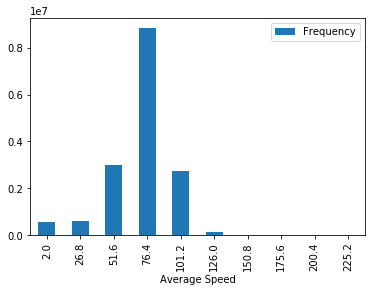

In [26]:
%%local
hist_df.set_index('Average Speed').plot(kind='bar')

# Fundamental Diagram of Traffic Flow

![Traffic Flow Diagram](https://upload.wikimedia.org/wikipedia/commons/5/59/Fundamental_Diagram.PNG)

We will plot the basic traffic flow diagrams for some of the detectors to get some insights into the properties of the traffic on the highway. In particular, the maximum flow and associated density. We will use that to select thresholds used in queue detection.

But first we need to calculate the density and add it as a new column to our dataset.

## Adding Density Column

In [27]:
df_E4N_D = df_E4N.withColumn('Density', col('Flow_In')*60/col('Average_Speed'))

In [28]:
df_E4N_D.printSchema()

root
 |-- Timestamp: timestamp (nullable = true)
 |-- Ds_Reference: struct (nullable = true)
 |    |-- Road: string (nullable = false)
 |    |-- Km_Ref: integer (nullable = false)
 |-- Detector_Number: short (nullable = true)
 |-- Flow_In: short (nullable = true)
 |-- Average_Speed: short (nullable = true)
 |-- Density: double (nullable = true)

In [29]:
df_E4N_D.show(20)

+-------------------+------------+---------------+-------+-------------+------------------+
|          Timestamp|Ds_Reference|Detector_Number|Flow_In|Average_Speed|           Density|
+-------------------+------------+---------------+-------+-------------+------------------+
|2016-06-01 00:00:00| [E4N,47465]|              2|      3|           93| 1.935483870967742|
|2016-06-01 00:00:00| [E4N,47465]|              3|      4|           75|               3.2|
|2016-06-01 00:00:00| [E4N,47800]|              2|      3|           91| 1.978021978021978|
|2016-06-01 00:00:00| [E4N,47800]|              3|      4|           81| 2.962962962962963|
|2016-06-01 00:00:00| [E4N,48290]|              2|      2|           98|1.2244897959183674|
|2016-06-01 00:00:00| [E4N,48290]|              3|      2|           83|1.4457831325301205|
|2016-06-01 00:00:00| [E4N,48620]|              3|      1|           84|0.7142857142857143|
|2016-06-01 00:00:00| [E4N,48935]|              3|      2|           69|1.739130

### Plotting Traffic Flow Diagrams

We select one detector and plot its values. In this example we use detector 'E4N 26,050' in the right most lane.

In [30]:
%%spark -o df1
df1 = df_E4N_D.filter((col('Ds_Reference.Road') == 'E4N') & \
                     (col('Ds_Reference.Km_Ref') == 26050) & \
                     (col('Detector_Number') == 1))

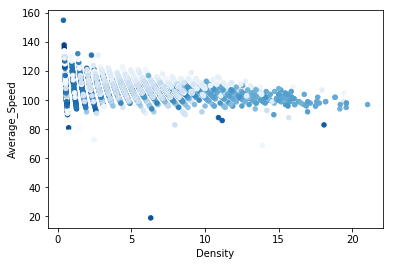

In [31]:
%%local
df1.plot.scatter(x = 'Density', y = 'Average_Speed', c= df1['Timestamp'].dt.hour, colormap='Blues', colorbar=False)

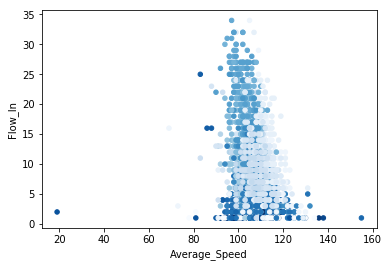

In [32]:
%%local
df1.plot.scatter(x = 'Average_Speed', y = 'Flow_In', c= df1['Timestamp'].dt.hour, colormap='Blues', colorbar=False )

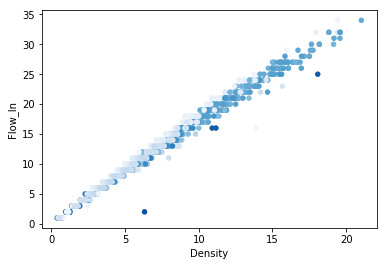

In [33]:
%%local
df1.plot.scatter(x = 'Density', y = 'Flow_In', c= df1['Timestamp'].dt.hour, legend=True, colormap='Blues', colorbar=False )

We plot for another detector. This one lies in a more congested area.

In [34]:
%%spark -o df2
df2 = df_E4N_D.filter((col('Ds_Reference.Road') == 'E4N') & \
                     (col('Ds_Reference.Km_Ref') == 68960) & \
                     (col('Detector_Number') == 1))

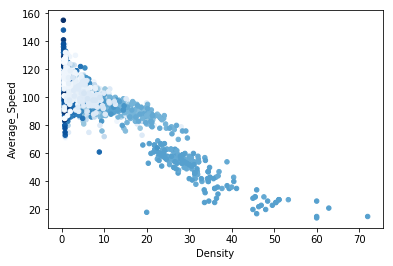

In [35]:
%%local
df2.plot.scatter(x = 'Density', y = 'Average_Speed', c= df2['Timestamp'].dt.hour, colormap='Blues', colorbar=False)

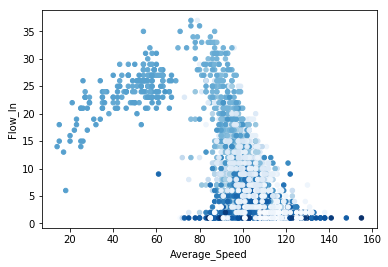

In [36]:
%%local
df2.plot.scatter(x = 'Average_Speed', y = 'Flow_In', c= df2['Timestamp'].dt.hour, colormap='Blues', colorbar=False)

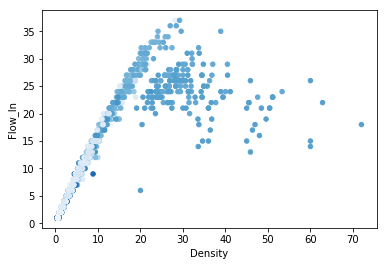

In [37]:
%%local
df2.plot.scatter(x = 'Density', y = 'Flow_In', c= df2['Timestamp'].dt.hour, colormap='Blues', colorbar=False)

# End of Queue Detection


<img src="img/Queue.png" alt="Queue Sign" style="width: 300px;"/>

To detect the end of queues we will use the **density** field we calculated. The end of the queue should be close to the detector that experienced a **sudden increase in density** compared to the density in the previous minute. The end of the queue considered an accident hazard in highways.

To calculate the difference in density we will use the **Window** function in Spark. A window partitions and sorts the data into groups. Then we can run a computation on the records in these groups (windows). In our example, we will partition the data by the detector unique ID (Ds_Reference + Detector_Number) so we will have all the data for one detector groupd in a window then we sort it by the time stamp.

In [38]:
w = Window.partitionBy('Ds_Reference', 'Detector_Number').orderBy('Timestamp')

Then we define two functions over these windows to calculate the dinsity difference and time difference. We use `lag()` to access the previous record in the sorted window.

In [39]:
densDiff = col('Density')- lag('Density', 1).over(w)
timeFmt = 'yyyy-MM-dd HH:mm:ss.SSS'
timeDiff = unix_timestamp('Timestamp', format=timeFmt) - lag(unix_timestamp('Timestamp', format=timeFmt)).over(w)

We use these functions to create two new columns in our dataset.

In [40]:
df_diff = df_E4N_D.withColumn('Density_Diff', densDiff).withColumn('timeDiff', timeDiff)

In [41]:
df_diff.show(20)

+-------------------+------------+---------------+-------+-------------+------------------+--------------------+--------+
|          Timestamp|Ds_Reference|Detector_Number|Flow_In|Average_Speed|           Density|        Density_Diff|timeDiff|
+-------------------+------------+---------------+-------+-------------+------------------+--------------------+--------+
|2016-06-01 00:48:00| [E4N,30710]|              2|      1|           28| 2.142857142857143|                null|    null|
|2016-06-01 02:27:00| [E4N,30710]|              2|      1|           36|1.6666666666666667|-0.47619047619047605|    5940|
|2016-06-01 02:33:00| [E4N,30710]|              2|      1|           99|0.6060606060606061| -1.0606060606060606|     360|
|2016-06-01 03:02:00| [E4N,30710]|              2|     11|          113|  5.84070796460177|   5.234647358541164|    1740|
|2016-06-01 03:03:00| [E4N,30710]|              2|     18|          102|10.588235294117647|   4.747527329515877|      60|
|2016-06-01 03:04:00| [E

Because we filtered the original dataset to contain only normal records (we removed records with error codes such as faulty detector or empty highway), some of the records in the window we defined might be more than a minute apart. We filter these records out using the timeDiff field we calculated.

In [42]:
df_diff_min = df_diff.filter(col('timeDiff') == 60)

In [43]:
df_diff_min.show(20)

+-------------------+------------+---------------+-------+-------------+------------------+--------------------+--------+
|          Timestamp|Ds_Reference|Detector_Number|Flow_In|Average_Speed|           Density|        Density_Diff|timeDiff|
+-------------------+------------+---------------+-------+-------------+------------------+--------------------+--------+
|2016-06-01 03:03:00| [E4N,30710]|              2|     18|          102|10.588235294117647|   4.747527329515877|      60|
|2016-06-01 03:04:00| [E4N,30710]|              2|     24|           96|              15.0|   4.411764705882353|      60|
|2016-06-01 03:05:00| [E4N,30710]|              2|     15|           97| 9.278350515463918|  -5.721649484536082|      60|
|2016-06-01 03:06:00| [E4N,30710]|              2|      8|          105| 4.571428571428571|  -4.706921944035347|      60|
|2016-06-01 03:07:00| [E4N,30710]|              2|     10|          100|               6.0|  1.4285714285714288|      60|
|2016-06-01 03:08:00| [E

Now that we calculated the density difference, all what is left is to find the detectors that cross certain thresholds that we define.

In [44]:
df_queue = df_diff_min.filter( (col('Density') > 30) & (col('Density_Diff') > 20) )

In [45]:
df_queue.count()

110621

In [46]:
df_queue.show(20)

+-------------------+------------+---------------+-------+-------------+------------------+------------------+--------+
|          Timestamp|Ds_Reference|Detector_Number|Flow_In|Average_Speed|           Density|      Density_Diff|timeDiff|
+-------------------+------------+---------------+-------+-------------+------------------+------------------+--------+
|2016-06-01 15:12:00| [E4N,30710]|              2|     25|           23| 65.21739130434783|29.217391304347828|      60|
|2016-06-01 15:35:00| [E4N,30710]|              2|     20|           20|              60.0|              34.5|      60|
|2016-06-01 15:37:00| [E4N,30710]|              2|     16|           13| 73.84615384615384| 40.24615384615384|      60|
|2016-06-01 15:39:00| [E4N,30710]|              2|     18|           13| 83.07692307692308|28.791208791208796|      60|
|2016-06-01 15:44:00| [E4N,30710]|              2|     17|           14| 72.85714285714286| 20.85714285714286|      60|
|2016-06-01 15:50:00| [E4N,30710]|      

# 3 - Visualization

Now that we have found the queue ends (in `df_queue` DataFrame), it is useful to visualize them on a **Map** and see them in action. We will use a map widget from [ipyleaflet](https://github.com/ellisonbg/ipyleaflet) to plot the Geo locations and use a **Text Box** to show the time.

In [47]:
%%local
from ipyleaflet import Map, GeoJSON, TileLayer
from geojson import FeatureCollection, Feature, MultiPolygon
import ipywidgets as widgets
from  datetime import timedelta, datetime
import time

# Uncomment the map you prefer from the ones below, or add your prefered map source
# Comment all and remove default_tiles to use the default map
#url = 'https://{s}.tile.openstreetmap.fr/hot/{z}/{x}/{y}.png'
url = 'http://a.tile.basemaps.cartocdn.com/light_all/{z}/{x}/{y}.png'
#url = 'http://{s}.tile.stamen.com/toner/{z}/{x}/{y}.png'

provider = TileLayer(url=url, opacity=1)
myMap =Map(default_tiles=provider, center=[59.334591, 18.063240], zoom=12, layout=widgets.Layout(width='130%', height='1000px'))
myMap.layout.height = '600px'
myMap.layout.width = '100%'

In [48]:
%%local
myMap

Map(center=[59.334591, 18.06324], layers=(TileLayer(options=[u'opacity', u'attribution', u'max_zoom', u'detect_retina', u'min_zoom', u'tile_size'], url=u'http://a.tile.basemaps.cartocdn.com/light_all/{z}/{x}/{y}.png'),), layout=Layout(height=u'600px', width=u'100%'), options=[u'keyboard_pan_offset', u'tap', u'attribution_control', u'max_zoom', u'min_zoom', u'bounce_at_zoom_limits', u'keyboard', u'scroll_wheel_zoom', u'dragging', u'inertia_max_speed', u'close_popup_on_click', u'zoom_control', u'box_zoom', u'double_click_zoom', u'tap_tolerance', u'zoom_start', u'keyboard_zoom_offset', u'inertia_deceleration', u'inertia', u'center', u'zoom', u'world_copy_jump', u'zoom_animation_threshold', u'touch_zoom'])

In [49]:
%%local
wgt = widgets.Text(value='Timestamp!', disabled=True)
wgt

Text(value=u'Timestamp!', disabled=True)

## Detector Metadata

To plot the data on the map we need the **GPS coordinates** of the detector. This metadata exists in a separate geographic information system (GIS). We exported the data into a csv file and converted the coordinates from the Swedish SWEREF99 standard to the GPS WGS84 standard for easier plotting on the map. 

Then we load the metadata into Spark.

In [50]:
schema_metadata = StructType() \
        .add('Y', DoubleType(), False) \
        .add('X', DoubleType(), False) \
        .add('DetectorId', ShortType(), False) \
        .add('McsDetecto', ShortType(), False) \
        .add('McsDsRefer', StringType(), False) \
        .add('LaneId', ShortType(), False) \
        .add('Bearing', ShortType(), True) \
        .add('Location', StringType(), True) \
        .add('RegionId', ShortType(), False) \
        .add('Entreprene', StringType(), True) \
        .add('StationId', ShortType(), False) \
        .add('SiteId', ShortType(), False) \
        .add('SiteValidF', TimestampType(), False) \
        .add('SiteValidT', TimestampType(), False) \
        .add('DetectorVa', TimestampType(), False) \
        .add('Detector_1', TimestampType(), False)

In [56]:
df_metadata_raw = spark.read.csv('hdfs:///Projects/labs/TrafficFlow/StockholmDetectorMetadata.csv', sep=';', schema=schema_metadata, \
                    ignoreLeadingWhiteSpace=True, ignoreTrailingWhiteSpace=True, \
                    header=True, \
                    timestampFormat='yyyy/MM/dd HH:mm:ss.SSS')

We split the Ds_Reference like we did with the flow data

In [57]:
df_metadata = df_metadata_raw.withColumn('McsDsRefer', split_ds_ref(col('McsDsRefer')))
df_metadata.printSchema()

root
 |-- Y: double (nullable = true)
 |-- X: double (nullable = true)
 |-- DetectorId: short (nullable = true)
 |-- McsDetecto: short (nullable = true)
 |-- McsDsRefer: struct (nullable = true)
 |    |-- Road: string (nullable = false)
 |    |-- Km_Ref: integer (nullable = false)
 |-- LaneId: short (nullable = true)
 |-- Bearing: short (nullable = true)
 |-- Location: string (nullable = true)
 |-- RegionId: short (nullable = true)
 |-- Entreprene: string (nullable = true)
 |-- StationId: short (nullable = true)
 |-- SiteId: short (nullable = true)
 |-- SiteValidF: timestamp (nullable = true)
 |-- SiteValidT: timestamp (nullable = true)
 |-- DetectorVa: timestamp (nullable = true)
 |-- Detector_1: timestamp (nullable = true)

## Plotting the Detectors on the Map

To verify the metada we will plot all detectors on the map. We extract the coordinates from the Spark DataFrame into a local Python list object then plot them.

In [58]:
%%spark -o coord_df
coord_df = df_metadata.select('Y','X')

We convert the coordinates into a GeoJson polygon that can be plotted by the map (small triangles)

In [59]:
%%local
features = []
for index, pos in coord_df.iterrows():
    p = MultiPolygon([ \
                      ([(pos['X'], pos['Y']), \
                        (pos['X']+0.000001, pos['Y']+0.000001), \
                        (pos['X']-0.000001, pos['Y']+0.000001), \
                        (pos['X'], pos['Y'])],) \
                     ])

    features.append(Feature(geometry=p, \
                    properties={'style':{'color': '#0000cd', 'fillColor': '#0000cd', 'fillOpacity': 1.0, 'weight': 6}}))

data = FeatureCollection(features)
g = GeoJSON(data=data)
    

We can check one of the points

In [60]:
%%local
data['features'][2]

{"geometry": {"coordinates": [[[[17.939260478657602, 59.388221402672897], [17.939261478657603, 59.388222402672895], [17.939259478657601, 59.388222402672895], [17.939260478657602, 59.388221402672897]]]], "type": "MultiPolygon"}, "properties": {"style": {"color": "#0000cd", "fillColor": "#0000cd", "fillOpacity": 1.0, "weight": 6}}, "type": "Feature"}

And verify that the GeoJson we created is valid

In [61]:
%%local
data.is_valid

True

Add the data to the map. Scroll up and you should see the locations of the detectors plotted on the map.

In [62]:
%%local
myMap.add_layer(g)

When you are done. Remov the detectors layer from the map to clean it up

In [63]:
%%local
myMap.remove_layer(g)

## Add Coordinates to Queue data

Now that we have the coordinates of the detectors, we need to add them to the queues we found so we can plot them. For that we use the **join** operation.

In [64]:
df_queue_coord = df_queue.alias('a').join(df_metadata.alias('b'), (col('a.Ds_Reference') == col('b.McsDsRefer')) \
                                           & (col('a.Detector_Number') == col('b.LaneId')))

In [65]:
df_queue_coord.printSchema()

root
 |-- Timestamp: timestamp (nullable = true)
 |-- Ds_Reference: struct (nullable = true)
 |    |-- Road: string (nullable = false)
 |    |-- Km_Ref: integer (nullable = false)
 |-- Detector_Number: short (nullable = true)
 |-- Flow_In: short (nullable = true)
 |-- Average_Speed: short (nullable = true)
 |-- Density: double (nullable = true)
 |-- Density_Diff: double (nullable = true)
 |-- timeDiff: long (nullable = true)
 |-- Y: double (nullable = true)
 |-- X: double (nullable = true)
 |-- DetectorId: short (nullable = true)
 |-- McsDetecto: short (nullable = true)
 |-- McsDsRefer: struct (nullable = true)
 |    |-- Road: string (nullable = false)
 |    |-- Km_Ref: integer (nullable = false)
 |-- LaneId: short (nullable = true)
 |-- Bearing: short (nullable = true)
 |-- Location: string (nullable = true)
 |-- RegionId: short (nullable = true)
 |-- Entreprene: string (nullable = true)
 |-- StationId: short (nullable = true)
 |-- SiteId: short (nullable = true)
 |-- SiteValidF: time

# Visualize Queue Locations

We extract the data we need from the joined table in Spark and get it locally into a Pandas DataFrame then loop through it and plot the queue ends we found on the map and show the time in the text box

In [66]:
%%spark -o pdf_queue_coord
pdf_queue_coord = df_queue_coord.select('Timestamp', 'X', 'Y', 'Density')

We can use the time stamp to get the queues at a specific time and the gps coordinates to plot them. For example:

In [67]:
%%local
pdf_queue_coord[pdf_queue_coord['Timestamp'] == datetime(2016,6,8,13,57,0)]

VBox(children=(HBox(), EncodingWidget(children=(VBox(children=(HTML(value=u'Encoding:'), Dropdown(description=u'X', layout=Layout(width=u'200px'), options={u'Y': u'Y', u'Timestamp': u'Timestamp', u'Density': u'Density', '-': None, u'X': u'X'}, value=None), HBox(children=(Dropdown(description=u'Y', layout=Layout(width=u'200px'), options={u'Y': u'Y', u'Timestamp': u'Timestamp', u'Density': u'Density', '-': None, u'X': u'X'}, value=None), Dropdown(description=u'Func.', index=2, layout=Layout(width=u'200px'), options={'Count': 'Count', 'Min': 'Min', 'Max': 'Max', 'Sum': 'Sum', '-': 'None', 'Avg': 'Avg'}, value='Max'))), Checkbox(value=False, description=u'Log scale X'), Checkbox(value=False, description=u'Log scale Y'))),))))

Output()

We define some helper functions that we will use in plotting.

Remove all layers on the map except the map tiles.

In [68]:
%%local
def map_cleanup(m):
    for l in m.layers:
        if type(l) != TileLayer:
            m.remove_layer(l)
            l.close()

Get all layers except the map tiles.

In [69]:
%%local
def map_get_layers(m):
    layers = []
    for l in m.layers:
        if type(l) != TileLayer:
            layers.append(l)
    return layers

Remove a given list of layers.

In [70]:
%%local
def map_cleanup_Layers(m, layers):
    for l in layers:
        m.remove_layer(l)
        l.close()

Plots coordinates in a Pandas DataFrame on the map.

In [71]:
%%local
def plot_pandas(pdf, m, color='#191970', opacity=0.5):
    features = []
    for index, row in pdf.iterrows():
        p = MultiPolygon([ \
                        ([(row['X'], row['Y']), \
                        (row['X']+0.0005, row['Y']+0.0005), \
                        (row['X']-0.0005, row['Y']+0.0005), \
                        (row['X'], row['Y'])],) \
                        ])

        features.append(Feature(geometry=p, \
                    properties={'style':{'color': color, 'fillColor': color, 'fillOpacity':opacity, 'weight': 5}}))

    data = FeatureCollection(features)
    g = GeoJSON(data=data)
    m.add_layer(g)
    

We loop through the data minute by minute from start time to end time. To improve the visualization, we plot the current minute in dark blue as well as the previous 3 minuts in lighter blue shades.

In [72]:
%%local
# Start Time
st = datetime(2016,6,6,5,0,0)

# End Time
et = datetime(2016,6,6,23,59,59)

# Time Delta
td = timedelta(minutes=1)

t1 = st
t2 = t1 + td
t3 = t2 + td
t4 = t3 + td

while t4 <= et:
    l = map_get_layers(myMap)
    plot_pandas(pdf_queue_coord[pdf_queue_coord['Timestamp'] == t1], myMap, '#e0ffff', opacity=0.7)
    plot_pandas(pdf_queue_coord[pdf_queue_coord['Timestamp'] == t2], myMap, '#b0c4de', opacity=0.8)
    plot_pandas(pdf_queue_coord[pdf_queue_coord['Timestamp'] == t3], myMap, '#6495ed', opacity=0.9)
    plot_pandas(pdf_queue_coord[pdf_queue_coord['Timestamp'] == t4], myMap, '#000080', opacity=1.0)
    
    # Update time of the Text Box
    wgt.value = t4.ctime()
    
    # You may break here to view a snapshot at a specific time instead of animation. Set st to the time you want to check
    # break
    
    map_cleanup_Layers(myMap, l)
    # Change the animation speed
    time.sleep(0.25)
    t1 = t1 + td
    t2 = t2 + td
    t3 = t3 + td
    t4 = t4 + td
    

## Cleanup the map

In [73]:
%%local
map_cleanup(myMap)

# Next Steps
## 1) Parquet Data Format vs. Original CSV

Parquet files are much more efficient than CSV files because they store data in binary and columnar format. Read [this](https://developer.ibm.com/hadoop/2016/01/14/5-reasons-to-choose-parquet-for-spark-sql/) for example.

You can test this yourself. We save our cleaned up data in parquet format then use it to load our E4N data. Compare the time!

In [81]:
df_cleanup2.write.save('hdfs:///Projects/demo_tensorflow_dowling0/Resources/sample_E4N.parquet', format='parquet')

In [82]:
df_E4N_test = spark.read.parquet('hdfs:///Projects/demo_tensorflow_dowling0/Resources/sample_E4N.parquet').select('Timestamp', 'Ds_Reference', 'Detector_Number', 'Flow_In', 'Average_Speed').where('Status == 3 AND Ds_Reference.Road == "E4N"')

In [84]:
df_E4N_test.count()

15868360

In [85]:
df_E4N_test.show(5)

+-------------------+------------+---------------+-------+-------------+
|          Timestamp|Ds_Reference|Detector_Number|Flow_In|Average_Speed|
+-------------------+------------+---------------+-------+-------------+
|2016-06-02 09:14:00| [E4N,40580]|              1|     18|          101|
|2016-06-02 09:14:00| [E4N,40580]|              2|     25|           86|
|2016-06-02 09:14:00| [E4N,40580]|              3|     18|           71|
|2016-06-02 09:14:00| [E4N,59440]|              1|     27|           70|
|2016-06-02 09:14:00| [E4N,59440]|              2|     18|           65|
+-------------------+------------+---------------+-------+-------------+
only showing top 5 rows

In [86]:
df_E4N_test.printSchema()

root
 |-- Timestamp: timestamp (nullable = true)
 |-- Ds_Reference: struct (nullable = true)
 |    |-- Road: string (nullable = true)
 |    |-- Km_Ref: integer (nullable = true)
 |-- Detector_Number: short (nullable = true)
 |-- Flow_In: short (nullable = true)
 |-- Average_Speed: short (nullable = true)

Check also the data size on disk. In my case the csv sample data was 40MB while the Parquet file we saved was 1.4MB!

## 2) Stream Processing Using Kafka and Spark Structured Streaming

The above method for queue detection can be easily converted into a streaming program using the new Spark Structured Streaming. For further reading on that, see [this](https://databricks.com/blog/2017/04/26/processing-data-in-apache-kafka-with-structured-streaming-in-apache-spark-2-2.html) tutorial to get started.



## 3) Graph Processing

Knowing the topological relationship between detectors is needed to do more complicated analytics. For example, knowing next/previous detector on the same lane, knowing detectors before/after lane split/merge.

One way to achieve this is by constructing a graph linking detectors together. Having this graph, we can use graph processing to do more advanced analytics. For example, we can detect queue ends better by looking at multiple consecutive sensors on the same lane.
